In [ ]:
import gc
from pathlib import Path

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from hydro_forecasting.data.caravanify_parquet import CaravanifyParquet, CaravanifyParquetConfig

---

In [104]:
COUNTRIES = ["CA", "CH", "CL", "USA", "camelsaus", "camelsgb", "camelsbr", "hysets", "lamah"]

# Base data directory - adjust this path as needed
BASE_DATA_DIR = Path("/Users/cooper/Desktop/CaravanifyParquet")

# Processing parameters
BATCH_SIZE = 100

# Country display names for plotting
COUNTRY_DISPLAY_NAMES = {
    "CA": "Kyrgyzstan and Tajikistan",
    "CH": "Switzerland",
    "CL": "Chile",
    "USA": "USA",
    "camelsaus": "Australia",
    "camelsgb": "Great Britain",
    "camelsbr": "Brazil",
    "hysets": "Canada (HYSETS)",
    "lamah": "Central Europe (LamaH)",
}

COUNTRY_PALETTE = {
    "CA": "#8E44AD",  # Brighter purple
    "CH": "#E74C3C",  # Brighter pink/red
    "CL": "#C0392B",  # Brighter red
    "USA": "#E67E22",  # Brighter orange
    "camelsaus": "#F39C12",  # Brighter yellow/gold
    "camelsgb": "#27AE60",  # Brighter green
    "camelsbr": "#16A085",  # Brighter teal
    "hysets": "#3498DB",  # Brighter blue
    "lamah": "#2980B9",  # Brighter steel blue
}

In [ ]:
def create_country_config(country: str, base_dir: Path) -> CaravanifyParquetConfig:
    """Create configuration for a specific country."""
    country_dir = base_dir / country / "post_processed"

    return CaravanifyParquetConfig(
        attributes_dir=country_dir / "attributes",
        timeseries_dir=country_dir / "timeseries" / "csv",
        gauge_id_prefix=country,
        use_hydroatlas_attributes=True,
        use_caravan_attributes=True,
        use_other_attributes=True,
    )


def extract_basin_metadata(caravan_instance: CaravanifyParquet, country: str) -> pd.DataFrame:
    """Extract metadata for all basins in the current batch."""
    basin_metadata = []

    for gauge_id, ts_df in caravan_instance.time_series.items():
        # Filter for valid streamflow data
        valid_data = ts_df.dropna(subset=["streamflow"])

        if len(valid_data) > 0:
            metadata = {
                "gauge_id": gauge_id,
                "country": country,
                "valid_start_date": valid_data["date"].min(),
                "valid_end_date": valid_data["date"].max(),
                "valid_record_count": len(valid_data),
                "total_record_count": len(ts_df),
            }
        else:
            metadata = {
                "gauge_id": gauge_id,
                "country": country,
                "valid_start_date": pd.NaT,
                "valid_end_date": pd.NaT,
                "valid_record_count": 0,
                "total_record_count": len(ts_df),
            }

        basin_metadata.append(metadata)

    return pd.DataFrame(basin_metadata)


def extract_daily_counts(caravan_instance: CaravanifyParquet) -> pd.DataFrame:
    """Extract daily counts of basins with valid streamflow data."""
    # Get all timeseries data and filter for valid streamflow
    ts_df = caravan_instance.get_time_series()[["gauge_id", "date", "streamflow"]]
    ts_df = ts_df.dropna(subset=["streamflow"])

    # Count unique gauge_ids per date
    daily_counts = ts_df.groupby("date")["gauge_id"].nunique().reset_index()
    daily_counts.columns = ["date", "basin_count"]

    # Clean up memory
    del ts_df
    gc.collect()

    return daily_counts


def clear_caravan_memory(caravan_instance: CaravanifyParquet):
    """Clear memory from CaravanifyParquet instance."""
    caravan_instance.time_series.clear()
    caravan_instance.static_attributes = pd.DataFrame()
    gc.collect()


def process_country_batches(
    country: str, config: CaravanifyParquetConfig, batch_size: int = 100
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Process all batches for a single country."""
    print(f"\n{'=' * 50}")
    print(f"Processing country: {country}")
    print(f"{'=' * 50}")

    # Initialize CaravanifyParquet instance
    caravan = CaravanifyParquet(config)

    # Get all gauge IDs for this country
    all_gauge_ids = caravan.get_all_gauge_ids()
    print(f"Total basins found: {len(all_gauge_ids)}")

    # Initialize result containers
    all_basin_metadata = []
    all_daily_counts = []

    # Process in batches
    n_batches = (len(all_gauge_ids) + batch_size - 1) // batch_size

    for batch_idx in tqdm(range(n_batches), desc=f"Processing {country} batches"):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(all_gauge_ids))
        batch_gauge_ids = all_gauge_ids[start_idx:end_idx]

        print(f"  Batch {batch_idx + 1}/{n_batches}: Processing {len(batch_gauge_ids)} basins")

        try:
            # Load stations for this batch
            caravan.load_stations(batch_gauge_ids)

            # Extract metadata
            batch_metadata = extract_basin_metadata(caravan, country)
            all_basin_metadata.append(batch_metadata)

            # Extract daily counts
            batch_daily_counts = extract_daily_counts(caravan)
            all_daily_counts.append(batch_daily_counts)

            # Clear memory for next batch
            clear_caravan_memory(caravan)

        except Exception as e:
            print(f"    Error processing batch {batch_idx + 1}: {e}")
            continue

    # Combine all batch results
    country_basin_metadata = pd.concat(all_basin_metadata, ignore_index=True) if all_basin_metadata else pd.DataFrame()

    # Combine and aggregate daily counts
    if all_daily_counts:
        combined_daily_counts = pd.concat(all_daily_counts, ignore_index=True)
        country_daily_counts = combined_daily_counts.groupby("date")["basin_count"].sum().reset_index()
    else:
        country_daily_counts = pd.DataFrame(columns=["date", "basin_count"])

    print(f"Completed {country}: {len(country_basin_metadata)} basins processed")

    return country_basin_metadata, country_daily_counts

In [ ]:
print("Starting streaming data processing...")
print(f"Countries to process: {COUNTRIES}")
print(f"Batch size: {BATCH_SIZE}")

# Initialize result containers
all_basin_metadata = []
daily_counts_by_country = {}

# Process each country
for country in COUNTRIES:
    try:
        # Create configuration
        config = create_country_config(country, BASE_DATA_DIR)

        # Process all batches for this country
        country_metadata, country_daily_counts = process_country_batches(country, config, BATCH_SIZE)

        # Store results
        all_basin_metadata.append(country_metadata)
        daily_counts_by_country[country] = country_daily_counts

    except Exception as e:
        print(f"Error processing country {country}: {e}")
        continue

# Combine all basin metadata
final_basin_metadata = pd.concat(all_basin_metadata, ignore_index=True) if all_basin_metadata else pd.DataFrame()

print(f"\n{'=' * 50}")
print("PROCESSING COMPLETE")
print(f"{'=' * 50}")
print(f"Total basins processed: {len(final_basin_metadata)}")
print(f"Countries with data: {list(daily_counts_by_country.keys())}")

In [106]:
if not final_basin_metadata.empty:
    print("\nSUMMARY STATISTICS:")
    print(f"{'=' * 30}")

    summary_stats = (
        final_basin_metadata.groupby("country")
        .agg(
            {
                "gauge_id": "count",
                "valid_start_date": "min",
                "valid_end_date": "max",
                "valid_record_count": ["sum", "mean"],
                "total_record_count": ["sum", "mean"],
            }
        )
        .round(2)
    )

    print(summary_stats)

    # Overall date range
    overall_start = final_basin_metadata["valid_start_date"].min()
    overall_end = final_basin_metadata["valid_end_date"].max()
    print(f"\nOverall date range: {overall_start} to {overall_end}")


SUMMARY STATISTICS:
          gauge_id valid_start_date valid_end_date valid_record_count  \
             count              min            max                sum   
country                                                                 
CA              78       2000-01-02     2024-05-22             542428   
CH             135       1981-01-02     2020-12-31            1904648   
CL             505       1951-01-01     2020-06-06            4552627   
USA            671       1980-01-01     2014-12-31            8185738   
camelsaus      222       1951-01-02     2014-12-31            3023524   
camelsbr       870       1980-01-01     2018-12-31           11469547   
camelsgb       671       1970-10-01     2015-09-30            8743165   
hysets       12162       1951-01-01     2018-12-31           88504138   
lamah          859       1981-01-01     2018-01-01           10007889   

                    total_record_count           
               mean                sum     mean  
co


Creating visualizations...


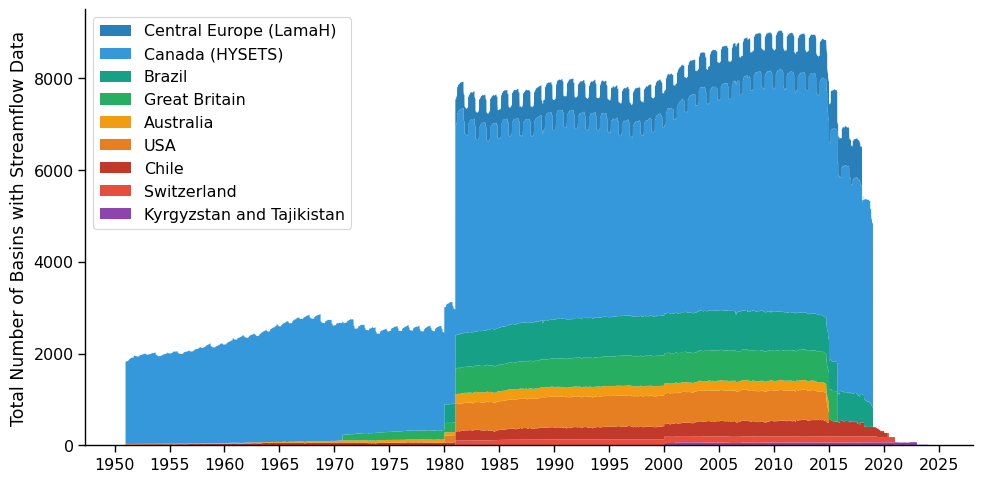


Processing complete! Results stored in:
- final_basin_metadata: DataFrame with 16173 basins
- daily_counts_by_country: Dict with daily counts for each country


In [107]:
if daily_counts_by_country:
    print("\nCreating visualizations...")

    # Set plotting style
    sns.set_context(context="paper", font_scale=1.3)

    # Create merged daily counts for stacked plot
    all_dates = pd.DataFrame(
        {"date": pd.to_datetime(sorted(set().union(*[df["date"] for df in daily_counts_by_country.values()])))}
    )

    # Merge all country data
    merged_counts = all_dates.copy()
    for country, daily_counts in daily_counts_by_country.items():
        merged_counts = merged_counts.merge(
            daily_counts.rename(columns={"basin_count": country}), on="date", how="left"
        )

    # Fill missing values with 0
    for country in COUNTRIES:
        if country in merged_counts.columns:
            merged_counts[country] = merged_counts[country].fillna(0)
        else:
            merged_counts[country] = 0

    merged_counts = merged_counts.sort_values("date")

    # Create stackplot
    plt.figure(figsize=(10, 5))

    # Only plot countries that have data
    countries_with_data = [
        c for c in COUNTRIES if c in daily_counts_by_country and not daily_counts_by_country[c].empty
    ]

    if countries_with_data:
        plt.stackplot(
            merged_counts["date"],
            *[merged_counts[country] for country in countries_with_data],
            labels=[COUNTRY_DISPLAY_NAMES.get(country, country) for country in countries_with_data],
            colors=[COUNTRY_PALETTE.get(country, "#888888") for country in countries_with_data],
        )

        # Format plot
        ax = plt.gca()
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
        ax.xaxis.set_major_locator(mdates.YearLocator(5))

        plt.ylabel("Total Number of Basins with Streamflow Data")

        # Reverse the legend to match visual stacking order (top to bottom)
        handles, labels = ax.get_legend_handles_labels()
        plt.legend(list(reversed(handles)), list(reversed(labels)), loc="upper left")

        plt.tight_layout()
        sns.despine()
        plt.savefig(
            "/Users/cooper/Desktop/hydro-forecasting/images/streamflow_data_availability.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.show()

print("\nProcessing complete! Results stored in:")
print(f"- final_basin_metadata: DataFrame with {len(final_basin_metadata)} basins")
print("- daily_counts_by_country: Dict with daily counts for each country")